###1.Data Setting

In [44]:
#1. 노트북 환경 체크 + 그래프 기본 설정
import sys, platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#-----------------------------------------------------------------------------

#1.1 Python/Numpy/Pandas 버전을출력
print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("pandas:", pd.__version__)

#1.2 그래프 설정
plt.rcParams['figure.dpi'] = 120      # 노트북/모니터에서 선명하게
plt.rcParams['axes.grid']  = True     # 기본 그리드 ON
plt.rcParams['font.size']  = 11       # 가독성 좋은 기본 폰트 크기
plt.rcParams['figure.figsize'] = (6,4) # 기본 그림 크기(옵션)

Python: 3.12.11
NumPy: 2.0.2
pandas: 2.2.2


In [45]:
#2. 내부 대류 열전달 계수 h
#-----------------------------------------------------------------------------

#2.1 물의 물성치
#물성치(물 20–80°C 근사): 단위 [k: W/m-K, mu: Pa·s, rho: kg/m³, cp: J/kg-K, Pr: -]
WATER = dict(k=0.6, mu=1.0e-3, rho=1000.0, cp=4180.0, Pr=7.0)


#2.2 내부 유동 Nusselt 수 근사, Re < 2300: 완전발달 층류에서 Nu≈3.66 / Re >= 2300: Dittus–Boelter (가열이면 지수 0.4)
def nusselt_internal_pipe(Re, Pr, heating=True):
  if Re < 2300:
      return 3.66
  else: #Re >= 2300
      if heating:
          n = 0.4
      else: #cooling
          n = 0.3
      return 0.023 * (Re**0.8) * (Pr**n)

#2.3 유속 U[m/s], 관내경 D_i[m] → 내부 대류계수 h[W/m^2-K]
def h_inner(U, D_i, fluid=WATER, heating=True):
    Re = fluid["rho"] * U * D_i / fluid["mu"]
    Nu = nusselt_internal_pipe(Re, fluid["Pr"], heating)
    h = Nu * fluid["k"] / D_i
    return h

In [46]:
#3. 속 빈 원통(고무 링)에서 반지름 방향 정상상태 전도 + 양면 대류 경계를 써서 온도 분포 T(r)
import numpy.linalg as la
#-----------------------------------------------------------------------------

#3.1 T(r) = C1 ln r + C2 / 경계: -k dT/dr|ri = hi (T(ri)-Ti_inf),  -k dT/dr|ro = ho (T(ro)-To_inf) / 선형 2x2로 C1,C2 결정
def hollow_cylinder_T_profile(ri, ro, hi, Ti_inf, ho, To_inf, k_solid=0.20, Nr_grid=400):
    M = np.array([[hi*np.log(ri) + k_solid/ri, hi],
                  [ho*np.log(ro) + k_solid/ro, ho]], dtype=float)

    rhs = np.array([hi*Ti_inf,ho*To_inf], dtype=float)

    C1, C2 = la.solve(M, rhs)
    r = np.linspace(ri, ro, Nr_grid)
    T = C1 * np.log(r) + C2
    return r, T

In [47]:
#4. 온도 → 물성/열팽창 → 응력(근사) → 라벨
#-----------------------------------------------------------------------------

#4.1 온도의존 등가 탄성계수 / 고무 등가 탄성계수: E(T)=E25*exp(-beta*(T-25))  [Pa]
def E_of_T(T_avg, E25=7e6, beta=0.01):
    return E25 * np.exp(-beta * (T_avg - 25.0))

#4.2 열팽창 변형률(분포) / 열팽창 변형률 분포 ε_th(r)≈alpha*(T(r)-T_ref)
def thermal_strain(T_profile, alpha=2.5e-4, T_ref=25.0):
    return alpha * (T_profile - T_ref)

#4.3 매우 단순화된 응력근사 / 평균 팽창 성분은 강체팽창으로 제거
#잔차(gradient)로 인해 생기는 '원주응력 유사' 항을 E/(1-nu) 배로 근사 / 2D에서 von Mises ~ |sigma_θ| 로 보수적으로 본다
def approx_max_von_mises_from_eps_th(eps_th, E, r, nu=0.49):
    eps_mech = -eps_th                  # 외벽 둘레변형≈0을 단순 확장
    sigma_theta = (E/(1.0 - nu)) * eps_mech
    max_vm = np.abs(sigma_theta).max()
    return float(max_vm), sigma_theta

#4.4 한 샘플 라벨 만들기 - h계산 → T(r) → E → ε_th(r) →σ → 라벨
def label_one_sample(U, T_in, T_amb, E25, beta, alpha, h_o,
                     ri=8e-3, ro=10e-3, k_rubber=0.20, D_i=16e-3, sigma_allow=100000): #허용응력 100Pa ~ 0.1MPa
    hi = h_inner(U, D_i=D_i)          # 내부 대류
    r, T = hollow_cylinder_T_profile(ri, ro, hi, T_in, h_o, T_amb, k_solid=k_rubber)
    T_avg = float(T.mean())
    E = E_of_T(T_avg, E25=E25, beta=beta)
    eps_th = thermal_strain(T, alpha=alpha)
    max_vm, sigma_theta = approx_max_von_mises_from_eps_th(eps_th, E,r)
    y_reg = max_vm
    y_cls = int(max_vm <= sigma_allow)  # 허용응력 이내면 1(합격)
    return dict(r=r, T=T, E=E, eps_th=eps_th, sigma_theta=sigma_theta, max_vm=y_reg, pass_flag=y_cls, hi=hi)

,U,T_in,T_amb,E25,beta,alpha,h_o,max_vm,pass
0,1.664374,76.241262,31.068299,8.316885e+06,0.015741,0.000222,16.386909,87640.962190,1
1,1.463327,84.165241,21.159737,7.376384e+06,0.010357,0.000266,7.971450,127022.545896,0
2,1.715159,77.580601,33.824379,5.979419e+06,0.017778,0.000277,19.229336,71951.215675,1
3,1.618421,78.046534,26.269865,7.982700e+06,0.008615,0.000217,8.910721,116418.854721,0
4,1.256506,87.645656,12.897472,5.337924e+06,0.013076,0.000204,6.523958,61162.438031,1


                 U         T_in        T_amb           E25         beta  \
count  1000.000000  1000.000000  1000.000000  1.000000e+03  1000.000000   
mean      1.498307    85.169912    22.321836  6.974289e+06     0.012289   
std       0.174951     5.786853     7.239286  1.161105e+06     0.004228   
min       1.200740    75.010375    10.024750  5.002569e+06     0.005014   
25%       1.344156    79.990122    16.118264  5.990773e+06     0.008635   
50%       1.496894    84.930080    22.386112  6.977951e+06     0.012186   
75%       1.655336    90.261067    28.647973  7.981519e+06     0.015891   
max       1.799463    94.988438    34.994133  8.997636e+06     0.019996   

             alpha          h_o         max_vm  
count  1000.000000  1000.000000    1000.000000  
mean      0.000249    17.399035  106743.194660  
std       0.000029     7.118055   33665.607120  
min       0.000200     5.010423   43557.728417  
25%       0.000224    11.326760   82638.280911  
50%       0.000249    17.41524

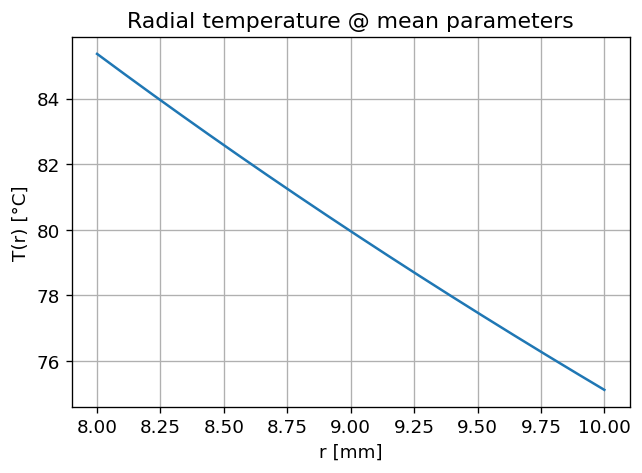

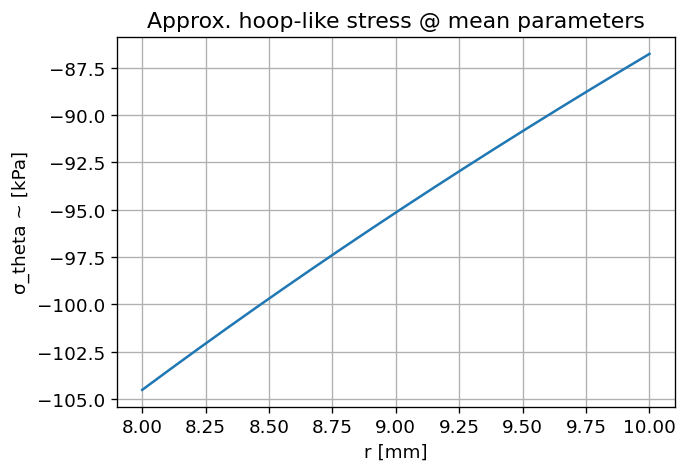

=== Mean parameters ===
     U: 1.49831
  T_in: 85.1699
 T_amb: 22.3218
   E25: 6.97429e+06
  beta: 0.0122891
 alpha: 0.000249041
   h_o: 17.399

approx max von Mises ~ 104.51 kPa,  h_i=5992 W/m²K,  dataset pass rate=46.40%


In [48]:
#5. 랜덤 데이터셋 생성 + 빠른 확인용 플롯
from numpy.random import default_rng
rng = default_rng(42)
#-----------------------------------------------------------------------------

#5.1 무작위로 생성한 열·유동·재료 파라미터에 해석 라벨(max_vm, pass)을 붙여 CSV로 저장, 요약 통계를 보여주는 데이터셋 생성 함수
def make_dataset_csv(N=1000, out_csv="dataset.csv"):
    U     = rng.uniform(1.2, 1.8, N)        # m/s
    T_in  = rng.uniform(75, 95, N)          # ℃
    T_amb = rng.uniform(10, 35, N)          # ℃
    E25   = rng.uniform(5e6, 9e6, N)        # Pa
    beta  = rng.uniform(0.005, 0.02, N)     # 1/℃
    alpha = rng.uniform(2.0e-4, 3.0e-4, N)  # 1/℃
    h_o   = rng.uniform(5, 30, N)           # 외부 대류 [W/m^2-K]

    rows = []
    for i in range(N):
        lab = label_one_sample(U[i],T_in[i],T_amb[i],E25[i],beta[i],alpha[i],h_o[i])
        rows.append([U[i],T_in[i],T_amb[i],E25[i],beta[i],alpha[i],h_o[i], lab["max_vm"], lab["pass_flag"]])
    df = pd.DataFrame(rows, columns=["U","T_in","T_amb","E25","beta","alpha","h_o","max_vm","pass"])
    df.to_csv(out_csv, index=False)
    return df

df = make_dataset_csv(N=1000)
display(df.head())
print(df.describe()[["U","T_in","T_amb","E25","beta","alpha","h_o","max_vm"]])


# 5.2 평균 파라미터로 온도/응력 분포 보기
# 주의: 개별 프로파일들의 평균이 아니라, "평균 파라미터"에서 계산한 단일 프로파일
mu = df[["U","T_in","T_amb","E25","beta","alpha","h_o"]].mean()

avg = label_one_sample(
    U=float(mu["U"]),
    T_in=float(mu["T_in"]),
    T_amb=float(mu["T_amb"]),
    E25=float(mu["E25"]),
    beta=float(mu["beta"]),
    alpha=float(mu["alpha"]),
    h_o=float(mu["h_o"])
)

r_mm = avg["r"] * 1e3

fig, ax = plt.subplots()
ax.plot(r_mm, avg["T"])
ax.set_xlabel("r [mm]")
ax.set_ylabel("T(r) [°C]")
ax.set_title("Radial temperature @ mean parameters")
plt.show()

fig, ax = plt.subplots()
ax.plot(r_mm, avg["sigma_theta"] / 1e3) #kpa
ax.set_xlabel("r [mm]")
ax.set_ylabel("σ_theta ~ [kPa]")
ax.set_title("Approx. hoop-like stress @ mean parameters")
plt.show()

pass_rate = float(df["pass"].mean())  # bool이면 True 비율로 계산됨
print("=== Mean parameters ===")
for k in ["U","T_in","T_amb","E25","beta","alpha","h_o"]:
    print(f"{k:>6}: {mu[k]:.6g}")
print(f"\napprox max von Mises ~ {avg['max_vm']/1e3:.2f} kPa,  "
      f"h_i={avg['hi']:.0f} W/m²K,  "
      f"dataset pass rate={pass_rate:.2%}")


#현실적인 범위에서 운전/재료 변수를 난수 샘플링하고, 각 샘플에 대해 물리 라벨러로 max_vm(회귀)와 pass(분류)를 생성
#학습용 데이터셋 CSV를 만든 다음, 평균 케이스의 T(r)와 응력 분포를 그림으로 확인하는 코드.
#이후에 scikit-learn / PyTorch 모델들이 학습할 입·출력 데이터를 공급하기 위해서 필요

###2.Machine Learning

In [49]:
#6. CSV에서 데이터 읽기 → 타깃/피처 지정 → 분류 라벨 불균형 점검/보조라벨 생성 → 학습/테스트 분할
from sklearn.model_selection import train_test_split
#-----------------------------------------------------------------------------

#6.1 CSV에서 데이터 가져오기
df = pd.read_csv('dataset.csv')
X_cols = ['U','T_in','T_amb','E25','beta','alpha','h_o']
y_reg  = 'max_vm'
y_cls  = 'pass'
#입력 피처(X_cols) 7개 열 이름 지정, 회귀 타깃(y_reg): 최대 등가응력 근사(max_vm), 분류 타깃(y_cls): 허용응력 기준 합/불(pass)



#6.2 분류 타깃 건강검진: 한쪽 클래스만 있으면 백업 라벨 생성(중앙값 기준)
counts = df[y_cls].value_counts()
if len(counts) < 2 or counts.min() < 20:
    print("[NOTE] pass 라벨이 불균형이라 보조 라벨(pass_median)을 생성합니다.")

    idx = np.arange(len(df))
    idx_tr, idx_te = train_test_split(idx, test_size=0.2, random_state=42, shuffle=True)
    thresh = np.median(df.loc[idx_tr, y_reg].values)
    df['pass_median'] = (df[y_reg] <= thresh).astype(int)
    y_cls = 'pass_median'
    print("Class counts:", df[y_cls].value_counts().to_dict())
else:
    print("Class counts:", counts.to_dict())
#클래스 불균형/편향 체크: pass 값 개수 세서클래스가 2개가 아니거나(len(counts) < 2)
#소수 클래스 샘플이 20개 미만이면 → 학습이 불안정하므로 보조 라벨을 만든다.
#보조 라벨 pass_median: 회귀 타깃 max_vm의 중앙값을 임계치로 두고 max_vm <= 중앙값 → 1, 그 외 0
#→ 이렇게 하면 양/음 클래스가 균형에 가깝게 만들어져 분류 실습이 가능.
#그 뒤 y_cls를 pass_median으로 바꿔서 아래 분할/학습에 사용.
#메모: 중앙값 임계치 생성은 라벨 정의이므로 누설(leakage) 문제는 크지 않지만, 엄밀히 하려면 “훈련 세트 중앙값”으로 만드는 게 더 깔끔함.



#6.3 피처·타깃 행렬 구성 및 층화 학습/테스트 분할
X = df[X_cols].values
y_r = df[y_reg].values
y_c = df[y_cls].values

X_train, X_test, y_r_train, y_r_test, y_c_train, y_c_test = train_test_split(
    X, y_r, y_c, test_size=0.2, random_state=42, stratify=y_c)

print("Train/Test shapes:", X_train.shape, X_test.shape)
#X: 입력 행렬 (Nx7), y_r: 회귀 타깃 벡터 ,y_c: 분류 타깃 벡터(기본 pass, 필요 시 pass_median)
#test_size=0.2: 테스트 20%, 학습 80%, random_state=42: 재현성 보장
#stratify=y_c: 층화 분할. → 학습/테스트에서 클래스 비율을 유지, 해당옵션은 y_c에 최소 2개 클래스가 있고 각 클래스 샘플이 충분히 있어야 작동
#6.2의 보조 라벨 생성 로직이 바로 이 전제(최소 샘플 수)를 보장하려는 장치


Class counts: {0: 536, 1: 464}
Train/Test shapes: (800, 7) (200, 7)


In [50]:
#7. 회귀 베이스라인들을 한 번에 학습·평가하는 코드
#(표준화+모델 파이프라인, GridSearchCV로 하이퍼파라미터 탐색, RMSE/R²계산)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
#필요한 모델/도구 임포트: 파이프라인, 표준화, 선형/릿지, SVR, 랜덤포레스트, 그리드서치, KFold, 평가지표
#-----------------------------------------------------------------------------


# 7.1 교차검증 설정 (KFold)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
#5-폴드 교차검증 분할자. 셔플+시드로 재현성 보장.


# 7.2 모델 파이프라인·그리드 정의
models = {
    # 7.2.1 Linear 파이프라인
    "Linear": make_pipeline(StandardScaler(with_mean=True, with_std=True), LinearRegression()),
    #선형회귀 파이프라인: 입력을 표준화한 뒤 LinearRegression에 투입. 표준화는 훈련 데이터로만 fit → train/test transform이 자동으로 보장됨(누설 방지).

    # 7.2.2 Ridge 그리드서치
    "RidgeGS": GridSearchCV(
        make_pipeline(StandardScaler(), Ridge()),
        param_grid={"ridge__alpha":[0.01,0.1,1,10,100]},
        cv=cv, n_jobs=-1
        # 릿지 회귀 + 그리드서치: 파이프라인 안의 Ridge 하이퍼파라미터는 ridge__alpha처럼 이름__파라미터 규칙으로 지정. cv=cv로 5-폴드, n_jobs=-1 병렬
    ),

    # 7.2.3 RandomForest 그리드서치
    "RF-GS": GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid={"n_estimators":[200,400], "max_depth":[None,8,12], "min_samples_leaf":[1,3]},
        cv=cv, n_jobs=-1
        #랜덤포레스트 회귀 + 그리드서치: 트리 개수/깊이/리프 최소샘플을 탐색.
    )
}


# 7.3 학습·예측 루프 및 지표 계산 (RMSE, R², best params)
rows = []
for name, mdl in models.items():
    mdl.fit(X_train, y_r_train)
    yhat = mdl.predict(X_test)
    rmse = mean_squared_error(y_r_test, yhat) ** 0.5
    r2   = r2_score(y_r_test, yhat)
    best = getattr(mdl, "best_params_", None)
    rows.append([name, rmse, r2, best])
    print(f"{name:12s}  RMSE={rmse: .4f}  R2={r2: .4f}  best={best}")
reg_results = pd.DataFrame(rows, columns=["model","rmse","r2","best_params"])


#각 모델(혹은 그리드서치 래퍼)에 대해 훈련→테스트 예측 실행.
#(GridSearchCV는 내부적으로 교차검증으로 최적 하이퍼파라미터를 선택한 뒤 .fit()이 끝나면 그 최적 모델로 다시 전체 훈련세트를 학습함.)
#RMSE와 R² 계산. (구버전 호환 위해 **0.5로 직접 제곱근), R²는 1에 가까울수록 좋고, 음수도 나올 수 있음(형편없는 예측).
#GridSearchCV인 경우 최적 하이퍼파라미터 딕셔너리(best_params_)를 가져오고(없으면 None), 결과를 표/로그로 저장.


#해당 코드는 네 가지 회귀 모델(선형, 릿지, SVR-RBF, 랜덤포레스트)에 대해 표준화/파이프라인을 올바르게 적용하고,
#교차검증 기반 하이퍼파라미터 탐색(GridSearchCV)으로 최적화한 뒤, 테스트셋 성능(RMSE, R²) 을 한 표로 비교한다.

Linear        RMSE= 7019.0830  R2= 0.9548  best=None
RidgeGS       RMSE= 7020.3912  R2= 0.9548  best={'ridge__alpha': 1}
RF-GS         RMSE= 5848.0175  R2= 0.9686  best={'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 400}


In [51]:
#8. 분류(pass/fail) 베이스라인들을 한 번에 학습·튜닝·평가하는 코드
# (Logistic/Decision Tree/Random Forest + GridSearchCV, 지표는 ACC/F1/ROC-AUC, 마지막에 혼동행렬/리포트)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
#-----------------------------------------------------------------------------

#8.1 분류 모델 파이프라인/그리드 정의
clf_models = {
    "LogReg": GridSearchCV(
        make_pipeline(StandardScaler(), LogisticRegression(max_iter=200, solver='lbfgs')),
        param_grid={"logisticregression__C":[0.1,1,5,10]},
        cv=cv, n_jobs=-1
        #로지스틱 회귀 파이프라인(표준화 → 로지스틱). GridSearchCV로 정규화 강도 C 탐색. cv=cv(앞에서 만든 KFold(5)), n_jobs=-1(병렬).
    ),
    "DT": GridSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_grid={"max_depth":[None,4,6,10], "min_samples_leaf":[1,3,5]},
        cv=cv, n_jobs=-1
        #의사결정나무: 깊이/리프 최소 샘플 탐색.
    ),
    "RF": GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid={"n_estimators":[200,400], "max_depth":[None,8,12], "min_samples_leaf":[1,3]},
        cv=cv, n_jobs=-1
        #랜덤포레스트: 트리 개수/깊이/리프 최소 샘플 탐색.
    )
}


# 8.2 학습·튜닝·평가 루프
rows = []
for name, mdl in clf_models.items():
    mdl.fit(X_train, y_c_train)
    ypred = mdl.predict(X_test)
    #각 모델(=GridSearchCV 래퍼)을 교차검증으로 튜닝하며 학습. 최적 파라미터로 훈련 세트 전체 재학습 후, 테스트셋에 예측 라벨 ypred.

    if hasattr(mdl, "predict_proba"):
        p = mdl.predict_proba(X_test)[:,1]
    else:
        # pipeline(SVC)일 때
        try:
            p = mdl.decision_function(X_test)
            # 스케일을 0-1로 단순 변환
            p = (p - p.min()) / (p.max()-p.min()+1e-9)
        except:
            p = None
    #양성 클래스 점수(확률/점수) 준비: 가능하면 predict_proba의 클래스1 확률 사용.
    #불가하면 decision_function(마진 점수)을 사용하고 min-max로 [0,1] 스케일링.
    #ROC-AUC는 단조 변환에 불변이므로 min-max로 바꿔도 AUC 평가는 타당.


    acc = accuracy_score(y_c_test, ypred)
    f1  = f1_score(y_c_test, ypred)
    auc = roc_auc_score(y_c_test, p) if p is not None else np.nan
    #정확도, F1(불균형에 좀 더 강함), ROC-AUC(확률/점수 기반 성능).
    #점수가 없으면 AUC는 계산하지 않고 NaN.

    rows.append([name, acc, f1, auc, getattr(mdl, "best_params_", None)])
    print(f"{name:8s}  ACC={acc:.3f}  F1={f1:.3f}  AUC={auc:.3f}  best={getattr(mdl,'best_params_',None)}")
    #결과 누적 및 로그 출력. best_params_로 최적 하이퍼파라미터 확인


# 8.3 최고 모델 혼동행렬 + 리포트(F1, AUC 우선)내림차순으로 정렬해 표시
# 혼동행렬/리포트(최상위 모델 하나)
clf_results = pd.DataFrame(rows, columns=["model","acc","f1","auc","best_params"])
clf_results.sort_values(["f1","auc"], ascending=False, inplace=True)
best_name = clf_results.iloc[0]['model']
best_mdl  = clf_models[best_name]
ypred = best_mdl.predict(X_test)
print("\nBest classifier:", best_name)
cm = confusion_matrix(y_c_test, ypred)
print(cm)

tn, fp, fn, tp = cm.ravel()
n_neg = tn + fp  # 실제 0(불합격) 개수
n_pos = tp + fn  # 실제 1(합격)   개수

print("\n[Confusion matrix interpretation]")
print(f"- 실제 0(불합격) {n_neg}개 중 {tn}개 맞춤, {fp}개를 합격으로 잘못 판단")
print(f"- 실제 1(합격)   {n_pos}개 중 {tp}개 맞춤, {fn}개를 불합격으로 잘못 판단")

print(classification_report(y_c_test, ypred, digits=3))
#테이블에서 1등 모델을 골라, 혼동행렬과 classification_report(정밀도/재현율/F1 지원) 출력.


#요약: 3가지 분류 알고리즘을 교차검증으로 튜닝, 정확도/ F1 / ROC-AUC로 테스트 성능을 비교, 최고 모델의 혼동행렬과 상세 리포트로 품질을 점검.
#팁/개선 포인트: 불균형이면 class_weight='balanced'(로지스틱/트리/포레스트) 옵션을 그리드에 포함하면 성능이 안정적일 수 있음.
#AUC가 NaN이면 해당 모델이 점수 함수를 제공하지 않은 경우.
#임계값 튜닝: 현재 predict()는 0.5 기준. 운영 목적이 누설 방지거나 미검출 최소화라면, predict_proba로 PR-곡선을 보고 임계값을 조정해 F1/recall을 맞추는 게 좋음.
#해석력: 트리/포레스트는 feature_importances_로 피처 영향도를 보기 좋고, 로지스틱은 계수(sign)로 해석 가능.

LogReg    ACC=0.965  F1=0.961  AUC=0.994  best={'logisticregression__C': 1}
DT        ACC=0.885  F1=0.877  AUC=0.937  best={'max_depth': 6, 'min_samples_leaf': 5}
RF        ACC=0.955  F1=0.951  AUC=0.991  best={'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 200}

Best classifier: LogReg
[[106   1]
 [  6  87]]

[Confusion matrix interpretation]
- 실제 0(불합격) 107개 중 106개 맞춤, 1개를 합격으로 잘못 판단
- 실제 1(합격)   93개 중 87개 맞춤, 6개를 불합격으로 잘못 판단
              precision    recall  f1-score   support

           0      0.946     0.991     0.968       107
           1      0.989     0.935     0.961        93

    accuracy                          0.965       200
   macro avg      0.968     0.963     0.965       200
weighted avg      0.966     0.965     0.965       200



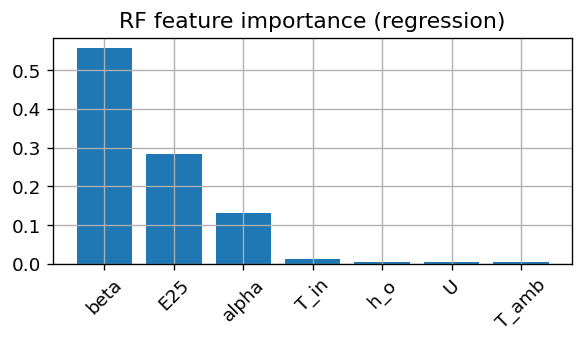

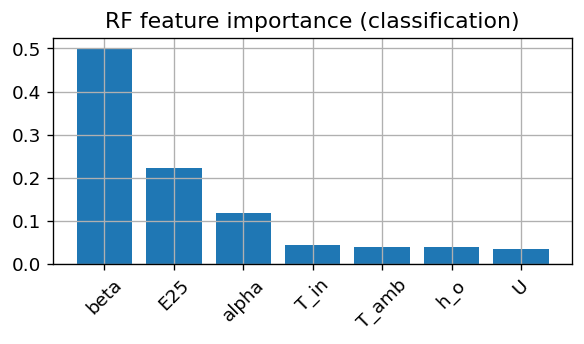

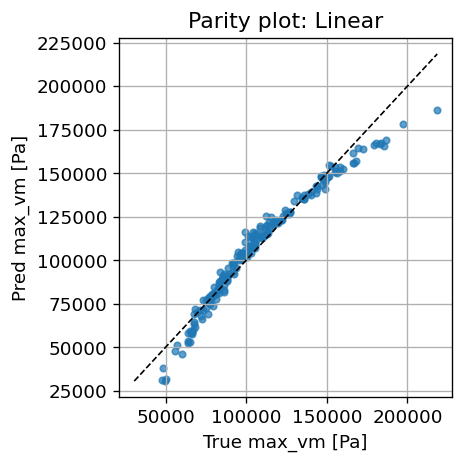

In [52]:
# 9. 랜덤포레스트 중요도 시각화 & 회귀 정합(Parity) 플롯
#-----------------------------------------------------------------------------

#9.0 (유틸) 공통 중요도 플로터
def _plot_rf_importance(importances, feature_names, title):
    plt.figure(figsize=(5,3))
    idx = np.argsort(importances)[::-1]
    plt.bar(range(len(feature_names)), importances[idx])
    plt.xticks(range(len(feature_names)), np.array(feature_names)[idx], rotation=45)
    plt.title(title)
    plt.tight_layout(); plt.show()

# 9.1 회귀용 RF 중요도 (models["RF-GS"])
#   - GridSearchCV면 best_estimator_에서 feature_importances_ 추출
try:
    rf_reg = models["RF-GS"]  # RandomForestRegressor + GridSearchCV
    rf_est = rf_reg.best_estimator_ if hasattr(rf_reg, "best_estimator_") else rf_reg
    importances = rf_est.feature_importances_
    _plot_rf_importance(importances, X_cols, "RF feature importance (regression)")
except Exception as e:
    print("RF regressor feature importance not available:", e)

# 9.2 분류용 RF 중요도 (clf_models["RF"])
try:
    rf_clf = clf_models["RF"]  # RandomForestClassifier + GridSearchCV
    rf_est = rf_clf.best_estimator_ if hasattr(rf_clf, "best_estimator_") else rf_clf
    importances = rf_est.feature_importances_
    _plot_rf_importance(importances, X_cols, "RF feature importance (classification)")
except Exception as e:
    print("RF classifier feature importance not available:", e)


# 9.3 회귀: 최고 성능 모델 정합(Parity) 플롯
#   - reg_results에서 RMSE 최저 모델명을 가져와 models[...]로 예측
try:
    best_reg_name = reg_results.iloc[0]['model']   # 예: "RF-GS" / "SVR-RBF-GS" 등
    best_reg      = models[best_reg_name]          # GridSearchCV여도 .predict로 최적기로 예측됨
    yhat = best_reg.predict(X_test)                # 테스트셋 예측

    plt.figure(figsize=(4,4))
    plt.scatter(y_r_test, yhat, s=15, alpha=0.7)
    lims = [min(y_r_test.min(), yhat.min()), max(y_r_test.max(), yhat.max())]
    plt.plot(lims, lims, 'k--', lw=1)
    plt.xlabel("True max_vm [Pa]"); plt.ylabel("Pred max_vm [Pa]")
    plt.title(f"Parity plot: {best_reg_name}")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Parity plot skipped:", e)


# (요약)
# - RF(회귀/분류)의 feature_importances_로 입력 변수 기여도 시각화
# - 회귀 최고 모델의 예측 vs 정답(Parity) 산점도로 전반적 정합도 확인
# (팁)
# - 트리 중요도 편향 보완: permutation importance/SHAP 병행 권장
# - Parity 패턴 확인: 곡률/꼬리쏠림 → 모델 개선 또는 데이터 보강 포인트

###3.PyTorch Surrogate Training

  50  train_MSE=1.3865e-01  val_MSE=1.2993e-01
 100  train_MSE=5.4991e-02  val_MSE=5.2219e-02
 150  train_MSE=2.2146e-02  val_MSE=2.1948e-02
 200  train_MSE=1.0627e-02  val_MSE=1.1503e-02
 250  train_MSE=6.7686e-03  val_MSE=7.9418e-03
 300  train_MSE=5.2316e-03  val_MSE=6.5297e-03
 350  train_MSE=4.4388e-03  val_MSE=5.8644e-03
 400  train_MSE=3.9339e-03  val_MSE=5.3343e-03
 450  train_MSE=3.5488e-03  val_MSE=4.9768e-03
 500  train_MSE=3.2464e-03  val_MSE=4.7052e-03
 550  train_MSE=3.0016e-03  val_MSE=4.4668e-03
 600  train_MSE=2.7840e-03  val_MSE=4.2937e-03
MLP Test RMSE = 1.7778e+04 Pa


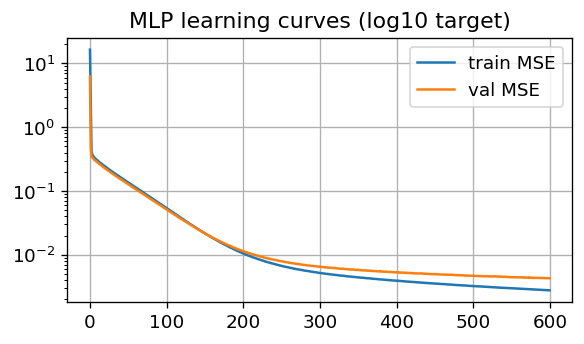

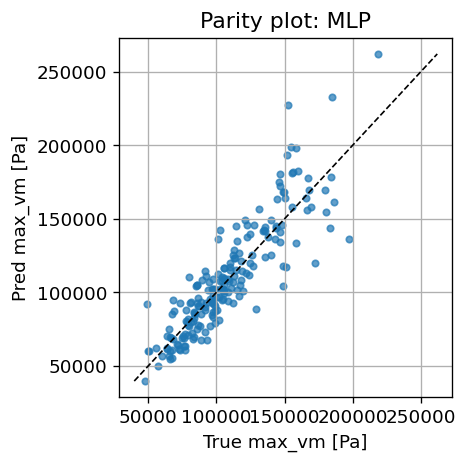

In [53]:
#10. 파이토치 옵티마이저 없이 순수 SGD 스텝으로 MLP를 학습·평가하는 “미니멀 학습 파이프라인"
# --- Minimal MLP training (no torch.optim, no scheduler) ---
import numpy as np
import torch, torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
#필요한 라이브러리 임포트. torch.optim을 아예 쓰지 않기 때문에 SymPy 충돌 같은 의존 문제를 피함.
# X_train, X_test, y_r_train, y_r_test 가 이미 존재한다고 가정 (이전 셀 에서 분할했던 그대로 사용)
#-----------------------------------------------------------------------------


#10.1 스케일링 + 타깃 log10
x_scaler = StandardScaler().fit(X_train)
Xtr = x_scaler.transform(X_train).astype(np.float32)
Xte = x_scaler.transform(X_test ).astype(np.float32)
ytr = np.log10(y_r_train).astype(np.float32).reshape(-1,1)
yte = np.log10(y_r_test ).astype(np.float32).reshape(-1,1)
#입력은 표준화(평균0/표준편차1): 신경망의 수렴 안정화.
#타깃(응력)은 log10 변환: 스케일을 줄여 MSE 안정화/극단값 영향 완화.
#파이토치 텐서로 바꾸기 전에 float32로 맞춘다



#10.2 Dataset / DataLoader
tr_ds = torch.utils.data.TensorDataset(torch.from_numpy(Xtr), torch.from_numpy(ytr))
te_ds = torch.utils.data.TensorDataset(torch.from_numpy(Xte), torch.from_numpy(yte))
tr_dl = torch.utils.data.DataLoader(tr_ds, batch_size=64, shuffle=True)
te_dl = torch.utils.data.DataLoader(te_ds, batch_size=256, shuffle=False)
#넘파이 → 텐서로 래핑해 배치 단위로 뽑을 수 있게 한다. 학습은 섞기(shuffle=True), 평가는 순서 유지.



#10.3 모델 정의 (2×128 ReLU)
class MLP(nn.Module):
    def __init__(self, d_in, d_hidden=128, d_out=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, d_hidden), nn.ReLU(),
            nn.Linear(d_hidden, d_hidden), nn.ReLU(),
            nn.Linear(d_hidden, d_out))
    def forward(self, x):
      return self.net(x)
#2개의 ReLU 은닉층(각 128) → 출력 1(= log10 응력 예측)인 기본 MLP 회귀. 배치정규화·드롭아웃 없이 깔끔한 베이스라인.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(d_in=Xtr.shape[1]).to(device)
lossf = nn.MSELoss()
# GPU가 있으면 CUDA 사용. 손실은 MSE(단, 타깃이 log10이므로 “로그공간 MSE”).



#10.4 하이퍼파라미터 & 초기화
lr = 3e-3          # 학습률
weight_decay = 1e-4 # L2 (수동 적용)
epochs = 600
patience = 80
#수동 SGD 스텝에 쓸 학습률과 L2 규제 계수. early stopping: 검증 성능이 80 epoch 동안 개선이 없으면 정지.

best_state, best_val = None, float('inf')
train_hist, val_hist = [], []
bad = 0
torch.manual_seed(0)
#최적 모델 파라미터를 저장할 버퍼, 학습/검증 곡선 기록, 시드 고정.



#10.5 학습 루프 (수동 SGD 업데이트)
for epoch in range(epochs):
    model.train()
    tr_loss_sum = 0.0
    n_tr = 0
    for xb, yb in tr_dl:
        xb = xb.to(device); yb = yb.to(device)
        # forward
        pred = model(xb)
        loss = lossf(pred, yb)
        # backward
        for p in model.parameters():
            if p.grad is not None:
                p.grad.detach_(); p.grad.zero_()
        loss.backward()
        # manual SGD step with weight decay
        with torch.no_grad():
            for p in model.parameters():
                if p.grad is None: continue
                # L2: grad += wd * p
                p.grad.add_(weight_decay * p)
                p.add_( -lr * p.grad )
        tr_loss_sum += float(loss.item()) * len(xb)
        n_tr += len(xb)
    tr_loss = tr_loss_sum / max(n_tr,1)
#수동 SGD: 일반적으로 opt.zero_grad(); loss.backward(); opt.step()를 쓰지만,
#여기서는 각 파라미터에 대해 grad += weight_decay * weight를 더해 L2 규제를 적용하고,
#param += -lr * grad로 직접 한 스텝 이동.
#이렇게 하면 torch.optim을 전혀 쓰지 않음 → 환경 의존 에러 회피, tr_loss는 로그공간 MSE의 epoch 평균.


    # validation MSE (NumPy로 계산)
    model.eval()
    with torch.no_grad():
        y_pred_list, y_true_list = [], []
        for xb, yb in te_dl:
            pr = model(xb.to(device)).cpu().numpy()
            y_pred_list.append(pr); y_true_list.append(yb.numpy())
        y_pred = np.vstack(y_pred_list).ravel()
        y_true = np.vstack(y_true_list).ravel()
        val_mse = mean_squared_error(y_true, y_pred)
        #검증 모드에서 로그공간 MSE를 계산. (학습/검증 일관성)


    train_hist.append(tr_loss)
    val_hist.append(val_mse)

    # early stopping
    if val_mse < best_val - 1e-8:
        best_val = val_mse
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        bad = 0
    else:
        bad += 1
    if (epoch+1) % 50 == 0:
        print(f"{epoch+1:4d}  train_MSE={tr_loss:.4e}  val_MSE={val_mse:.4e}")
    if bad >= patience:
        print(f"Early stop at epoch {epoch+1}")
        break
        #조기 종료: val_mse가 갱신되면 best_state 저장, 아니면 bad 증가.    50 epoch마다 로그 출력.


# 10.6 베스트 복원 & 테스트 RMSE (원공간 Pa)
if best_state is not None:
    model.load_state_dict(best_state)
model.eval()
with torch.no_grad():
    yhat_log = model(torch.from_numpy(Xte).to(device)).cpu().numpy().ravel()
yhat = 10.0**yhat_log
rmse = mean_squared_error(y_r_test, yhat) ** 0.5
print(f"MLP Test RMSE = {rmse:.4e} Pa")
# 가장 좋은(검증 MSE 최소) 파라미터로 복원.  **로그 예측을 원공간(파)**로 되돌린 뒤 **RMSE(파 단위)**로 최종 성능을 보고.



# 10.7 학습/검증 곡선
plt.figure(figsize=(5,3))
plt.plot(train_hist, label='train MSE')
plt.plot(val_hist,   label='val MSE')
plt.yscale('log'); plt.legend(); plt.title("MLP learning curves (log10 target)")
plt.tight_layout(); plt.show()
#로그공간 MSE의 학습/검증 곡선. 과적합 여부, 수렴 상태를 시각적으로 확인.



# 10.8 정합(Parity) 플롯 (원공간)
plt.figure(figsize=(4,4))
plt.scatter(y_r_test, yhat, s=15, alpha=0.7)
lims = [min(y_r_test.min(), yhat.min()), max(y_r_test.max(), yhat.max())]
plt.plot(lims, lims, 'k--', lw=1)
plt.xlabel("True max_vm [Pa]"); plt.ylabel("Pred max_vm [Pa]")
plt.title("Parity plot: MLP")
plt.tight_layout(); plt.show()
#**원공간(파)**에서 정답 vs 예측 산점도(Parity). 대각선 주변에 모일수록 성능이 좋다.

#전체 요약: 이 코드는 입력 표준화 + 타깃 log10으로 안정화하고, 간단 MLP(2 x 128 ReLU) 를 수동 SGD로 학습(MSE with L2), 조기 종료, 테스트 RMSE(파), 학습곡선/정합 플롯을 출력한다.
#torch.optim을 안 쓰므로 환경 의존 문제(Adam/AdamW/SymPy 등)를 완전히 회피하면서도, 학습 품질은 베이스라인으로 충분하다.
#이해 포인트 / 조절 팁: 성능↑: d_hidden↑, 층 추가, 드롭아웃/BN 추가, 학습률 스케줄, 표본 수↑.
#규제: weight_decay는 SGD의 L2 규제 형태(AdamW의 decoupled WD와는 다름).
#손실 공간: 학습/검증은 로그공간 MSE, 최종 리포트는 원공간 RMSE → 보고서에 둘 다 언급하면 친절함.
#재현성: StandardScaler는 train으로 fit 후 train/test에 같은 변환을 적용(데이터 누설 방지).


###4.Sensitivity Analysis

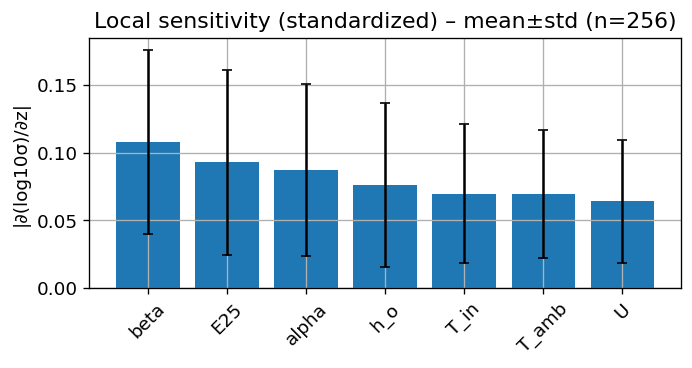

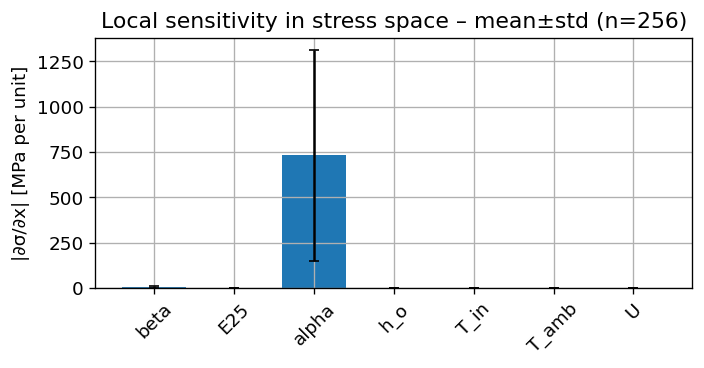

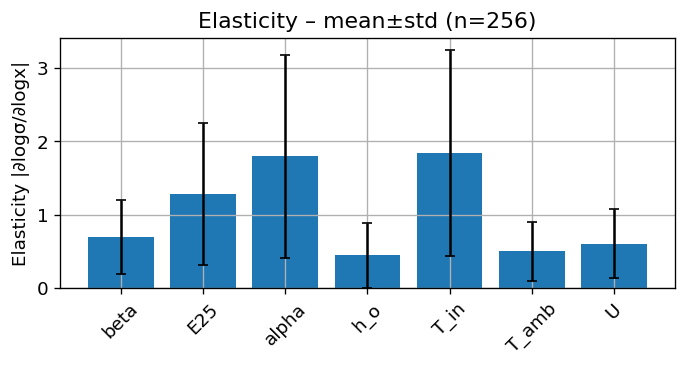

In [11]:
# 11. MLP가 예측하는 값(로그 응력) 이 입력 피처들에 얼마나 민감한지를, 한 점(x0)에서의 국소 기울기(gradient) 로 보는 코드
#   - 한 샘플 x0에서 y=log10(sigma)의 ∂y/∂x 계산
#   - 표준화 입력 기준 민감도 막대그래프
#   - (옵션) 원단위/원응력 기준 민감도 환산 코드 포함
import numpy as np
import torch
import matplotlib.pyplot as plt
#-----------------------------------------------------------------------------

#11.1 평가 모드
model.eval()

# 1) 샘플 여러 개 선택 (표준화 입력 Xtr에서 무작위 선택)
n_pick = min(256, len(Xtr))   # 원하면 64/128/512 등으로 조절
idx = np.random.choice(len(Xtr), size=n_pick, replace=False)
xb = torch.from_numpy(Xtr[idx]).to(device).requires_grad_(True)  # (n, d)

# 2) 순전파: y = log10(sigma)
y = model(xb)  # (n, 1)

# 3) 입력 기울기: d(log10σ)/dz (z=표준화 좌표)
grads = torch.autograd.grad(y, xb, grad_outputs=torch.ones_like(y))[0]  # (n, d)
G = grads.detach().cpu().numpy()

# 4) 표준화 좌표 기준 민감도(절댓값)의 평균/표준편차
Az = np.abs(G)                         # (n, d)
m_z = Az.mean(axis=0)                  # (d,)
s_z = Az.std(axis=0)                   # (d,)

# 5) 원단위로 환산: d(log10σ)/dx = d(log10σ)/dz / std(x)
Axo = Az / x_scaler.scale_[None, :]    # (n, d)
m_x = Axo.mean(axis=0)
s_x = Axo.std(axis=0)

# 6) 응력 단위(Pa per unit): dσ/dx = (ln10)*σ*d(log10σ)/dx
with torch.no_grad():
    sigma = (10.0 ** y.detach()).cpu().numpy().ravel()  # (n,)
dSigma = (np.log(10.0) * sigma[:, None]) * (G / x_scaler.scale_[None, :])  # (n, d)
As  = np.abs(dSigma)
m_s = As.mean(axis=0)
s_s = As.std(axis=0)

# 7) 시각화: 중요도 큰 순으로 정렬
order = np.argsort(-m_z)
labels = np.array(X_cols)[order]

x_batch = x_scaler.inverse_transform(Xtr[idx])        # (n, d) 원단위
eps = 1e-12
Elas = np.abs((x_batch / (sigma[:, None] + eps)) * dSigma)  # (n, d)  무차원

m_e = Elas.mean(axis=0)   # 평균 탄력도
s_e = Elas.std(axis=0)

plt.figure(figsize=(6,3.2))
plt.bar(range(len(X_cols)), m_z[order], yerr=s_z[order], capsize=3)
plt.xticks(range(len(X_cols)), labels, rotation=45)
plt.ylabel('|∂(log10σ)/∂z|')
plt.title('Local sensitivity (standardized) – mean±std (n={})'.format(n_pick))
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3.2))
plt.bar(range(len(X_cols)), (m_s[order]/1e6), yerr=(s_s[order]/1e6), capsize=3)
plt.xticks(range(len(X_cols)), labels, rotation=45)
plt.ylabel('|∂σ/∂x| [MPa per unit]')
plt.title('Local sensitivity in stress space – mean±std (n={})'.format(n_pick))
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3.2))
plt.bar(range(len(X_cols)), m_e[order], yerr=s_e[order], capsize=3)
plt.xticks(range(len(X_cols)), labels, rotation=45)
plt.ylabel('Elasticity |∂logσ/∂logx|')
plt.title(f'Elasticity – mean±std (n={n_pick})')
plt.tight_layout(); plt.show()

In [12]:
#12번 점검 FD(유한차분)  vs grad(그래디언트) 값이 동일/ 구현/스케일변환이 일관적
import numpy as np
import torch

np.random.seed(0)
check_idx = np.random.choice(len(Xtr), size=min(64, len(Xtr)), replace=False)
eps = 0.01  # +1% 변화
log10_step = np.log10(1.0 + eps)

def pred_logsig_from_Xorig(X_orig):
    Z = x_scaler.transform(X_orig.astype(np.float32))
    with torch.no_grad():
        y = model(torch.from_numpy(Z).to(device)).cpu().numpy().ravel()  # log10(sigma)
    return y

# 원단위 기준의 기준점/perturb
X0_orig = x_scaler.inverse_transform(Xtr[check_idx])  # (n,d) 원단위
y0 = pred_logsig_from_Xorig(X0_orig)

fd_means = {}
grad_means = {}

# 그래디언트 기반 탄력도 (같은 샘플에서)
xb = torch.from_numpy(Xtr[check_idx]).to(device).requires_grad_(True)
y = model(xb)                  # log10 sigma
grads_z = torch.autograd.grad(y, xb, grad_outputs=torch.ones_like(y))[0].cpu().numpy()  # d(log10σ)/dz
grads_x = grads_z / x_scaler.scale_[None, :]  # d(log10σ)/dx
elas_grad = np.log(10.0) * (X0_orig * grads_x)  # dlogσ/dlogx (base10)

for j, name in enumerate(X_cols):
    X1 = X0_orig.copy()
    X1[:, j] *= (1.0 + eps)                     # 원단위로 1% 곱셈
    y1 = pred_logsig_from_Xorig(X1)
    elas_fd = (y1 - y0) / log10_step            # Δlog10σ / Δlog10x
    fd_means[name] = float(elas_fd.mean())
    grad_means[name] = float(elas_grad[:, j].mean())

for name in X_cols:
    print(f"{name:>6}: FD mean={fd_means[name]:8.3f}, grad mean={grad_means[name]:8.3f}")


     U: FD mean=   0.002, grad mean=  -0.045
  T_in: FD mean=   0.443, grad mean=   0.319
 T_amb: FD mean=   0.112, grad mean=   0.090
   E25: FD mean=   1.063, grad mean=   1.001
  beta: FD mean=  -0.689, grad mean=  -0.692
 alpha: FD mean=   1.144, grad mean=   1.100
   h_o: FD mean=   0.164, grad mean=   0.150


###5.Thermal-stress Simulation and Fatigue Assessment

In [54]:
# 13. 피로 해석 기반 함수: ① 레인플로우 ② ε–N 수명 ③ 온도 시나리오
import numpy as np

# 13.1 턴닝포인트 + 노이즈 컷
def _turning_points(y, eps=0.0):
    y = np.asarray(y, float); y = y[np.isfinite(y)]
    if y.size < 3: return y.copy()
    dy = np.diff(y); nz = np.flatnonzero(dy != 0.0)
    if nz.size == 0: return y[:1].copy()
    y2 = y[np.r_[0, nz + 1]];
    if y2.size < 3: return y2.copy()
    s = np.sign(np.diff(y2)); s[s==0]=1.0
    idx = np.where(s[1:]*s[:-1] < 0.0)[0] + 1
    yv  = y2[np.r_[0, idx, len(y2)-1]]
    if eps > 0.0:
        keep=[0]
        for k in range(1,len(yv)):
            if abs(yv[k]-yv[keep[-1]]) >= eps: keep.append(k)
        yv = yv[keep]
    return yv

# 13.2 레인플로우 (range, mean, count)
def rainflow(series, eps=0.0):
    y = _turning_points(series, eps=eps)
    if y.size < 2: return np.zeros((0,3), float)
    S, out = [], []
    for x in y:
        S.append(x)
        while len(S) >= 3:
            x1,x2,x3 = S[-3],S[-2],S[-1]
            r1, r2 = abs(x2-x1), abs(x3-x2)
            if r1 <= r2:
                out.append((r1,0.5*(x1+x2),1.0)); S.pop(-2)
            else: break
    for i in range(len(S)-1):
        out.append((abs(S[i+1]-S[i]), 0.5*(S[i+1]+S[i]), 0.5))
    out = np.asarray(out, float)
    return out[np.isfinite(out).all(axis=1)] if out.size else out

# 13.3 ε–N Miner 손상 (고무용). Nf = (eps0/eps_a)^b
def miner_from_strain_eN(sigma_series, T_in_series, const_params,
                         eps0=0.30, b=4.0, rf_eps=0.0, eps_e=None):
    """
    sigma_series: σ(t) [Pa], T_in_series: [°C]
    const_params: dict(E25, beta) 사용 (없으면 기본값으로 처리)
    eps0, b : ε–N 파라미터 (무차원), eps_e: 피로한계(진폭)
    반환: (D, rf, Nf)
    """
    sig = np.asarray(sigma_series, float); Tin = np.asarray(T_in_series, float)
    if sig.size == 0 or Tin.size != sig.size:
        return 0.0, np.zeros((0,3), float), np.array([], float)
    E25 = float(const_params.get('E25', 7.5e6))
    beta= float(const_params.get('beta', 0.01))
    E_t = E25 * np.exp(-beta*(Tin - 25.0))        # [Pa]
    eps_t = sig / np.maximum(E_t, 1e3)            # 변형률 시계열
    rf = rainflow(eps_t, eps=rf_eps)
    if rf.size == 0: return 0.0, rf, np.array([], float)
    eps_a = rf[:,0]/2.0; cnt = rf[:,2]
    mask = np.ones_like(eps_a, bool) if eps_e is None else (eps_a >= float(eps_e))
    Nf = np.full_like(eps_a, np.inf, float)
    sel = mask & (eps_a > 0)
    if np.any(sel):
        Nf[sel] = (np.maximum(eps0,1e-12)/eps_a[sel])**b
    D = float(np.sum(cnt[mask] / np.maximum(Nf[mask], 1e-12)))
    return D, rf, Nf

# 13.4 온도 시나리오(랜덤, 선택적 1차 스무딩)
def scenario_noise(total_h=6, dt_s=2, Tm=80.0, noise_deg=5.0,
                   seed=42, uniform=True, smooth_tau_s=0.0,
                   U=1.2, T_amb=25.0, E25=7.5e6, beta=0.01, alpha=2.5e-4, h_o=10.0):
    t = np.arange(0, total_h*3600, dt_s, float)
    rng = np.random.default_rng(seed)
    noise = rng.uniform(-noise_deg, +noise_deg, size=t.shape) if uniform \
            else np.clip(rng.normal(0.0, noise_deg/3.0, size=t.shape), -noise_deg, +noise_deg)
    if smooth_tau_s and smooth_tau_s > 0.0:
        a = dt_s / max(smooth_tau_s, 1e-9); y = np.empty_like(noise); y[0]=noise[0]
        for i in range(1,len(noise)): y[i] = y[i-1] + (noise[i]-y[i-1])*a
        noise = y
    T_in = Tm + noise
    const = dict(U=U, T_amb=T_amb, E25=E25, beta=beta, alpha=alpha, h_o=h_o)
    return t, T_in, const

In [55]:
#14. 시간에 따라 변하는 유입 온도 시리즈)**를 넣으면, 학습된 MLP 서로게이트 모델로
#각 시점의 최대 등가응력 σ_max(t) 을 예측해 시계열로 돌려주는 헬퍼 함수
import numpy as np
import torch

_ylog_train = np.log10(np.asarray(y_r_train, float))
_ylog_train = _ylog_train[np.isfinite(_ylog_train)]
_YLOG_MIN, _YLOG_MAX = np.percentile(_ylog_train, [0.5, 99.5])

def _pow10_soft_clamp(y_log):
    y = np.asarray(y_log, np.float64)
    # 경계 밖 값은 부드럽게 눌러줌 (overflow/NaN 방지)
    span = max(_YLOG_MAX - _YLOG_MIN, 1e-6)
    z = (y - (_YLOG_MIN + _YLOG_MAX)/2) / (span/2)
    y_soft = (_YLOG_MIN + _YLOG_MAX)/2 + np.tanh(z) * (span/2 - 1e-3)
    return np.power(10.0, y_soft, dtype=np.float64)

@torch.no_grad()
def predict_sigma_series(T_in_series, const_params, x_scaler, model, device='cpu'):
    n = len(T_in_series)
    X = np.zeros((n, len(X_cols)), dtype=np.float32)

    # 고정 파라미터 채우기 + 시간변화는 T_in만 덮어쓰기
    X[:, X_cols.index('U')]     = const_params['U']
    X[:, X_cols.index('T_in')]  = T_in_series
    X[:, X_cols.index('T_amb')] = const_params['T_amb']
    X[:, X_cols.index('E25')]   = const_params['E25']
    X[:, X_cols.index('beta')]  = const_params['beta']
    X[:, X_cols.index('alpha')] = const_params['alpha']
    X[:, X_cols.index('h_o')]   = const_params['h_o']

    Xs = x_scaler.transform(X).astype(np.float32)
    model.eval()
    y_log = model(torch.from_numpy(Xs).to(device)).cpu().numpy().ravel()
    sigma = _pow10_soft_clamp(y_log)  # [Pa]
    return sigma

[strain amplitude ε_a]  min=0.000000, median=0.000032, max=0.001091  (fraction)
   p01=0.000001, p05=0.000003, p10=0.000006, p90=0.000096, p95=0.000129
   → [%] median=0.0032%, p90=0.0096%
EPS_E candidates (fraction): conservative≈0.000006, typical≈0.000016, loose≈0.000008
                        [%]: 0.0006%, 0.0016%, 0.0008%


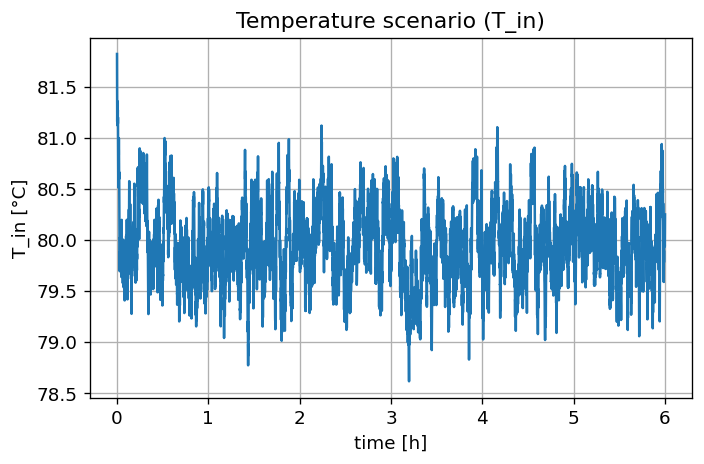

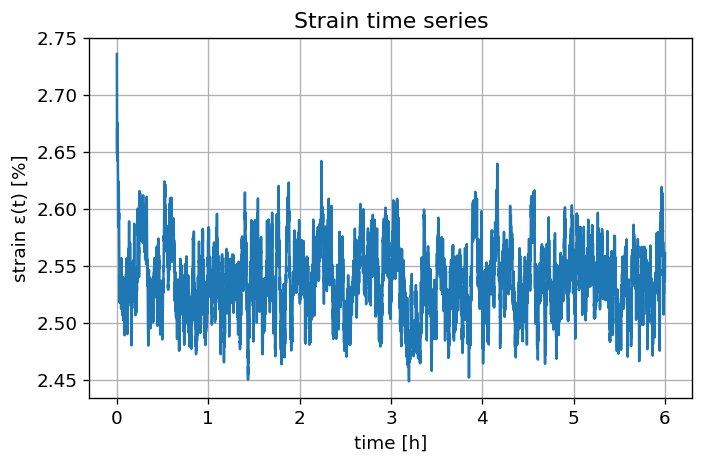

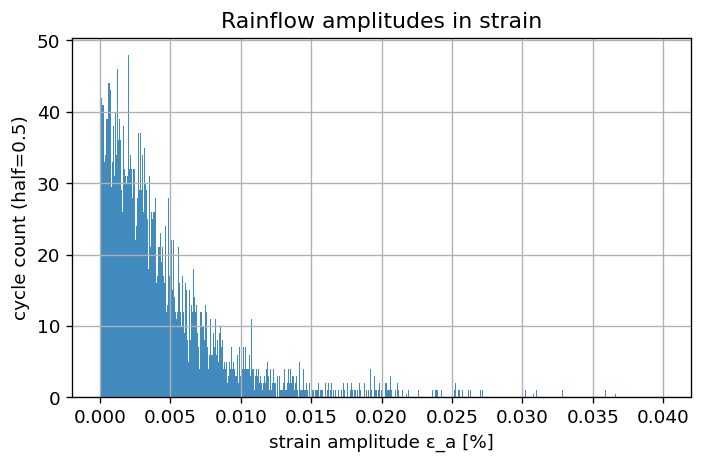

In [60]:
# 15. 변형률 진단(요약/플롯) — 중복 제거 버전
# 전제: tN, TinN, constN, sigmaN 가 준비되어 있고, E_of_T / rainflow 가 정의되어 있음.


DT_S = 2
tN, TinN, constN = scenario_noise(
    total_h=6, dt_s=DT_S,
    Tm=80.0, noise_deg=5.0,
    seed=123, smooth_tau_s=60.0,
    U=1.2, T_amb=25.0, E25=7.5e6, beta=0.01, alpha=2.5e-4, h_o=10.0
)
sigmaN = predict_sigma_series(TinN, constN, x_scaler, model, device)
record_hours_N = (len(tN) * DT_S) / 3600.0



# 15.1 변형률 시계열
E_t   = E_of_T(TinN, E25=constN['E25'], beta=constN['beta'])   # [Pa]
eps_t = sigmaN / E_t                                           # [-]
eps_pct = 100.0 * eps_t                                        # [%]

# 15.2 레인플로우로 진폭 분해
rf_eps = rainflow(eps_t, eps=0.0)      # (range, mean, count)
eps_a  = rf_eps[:, 0] / 2.0            # 진폭 [-]
w      = rf_eps[:, 2]                  # 카운트(half=0.5)
eps_a_pct = 100.0 * eps_a              # [%]

# 15.3 요약 통계 & 피로한계(ε_e) 후보
q = lambda p: float(np.percentile(eps_a, p))
mins, med, maxs = float(eps_a.min()), float(np.median(eps_a)), float(eps_a.max())
q1, q5, q10, q90, q95 = (q(p) for p in (1, 5, 10, 90, 95))
print(f"[strain amplitude ε_a]  min={mins:.6f}, median={med:.6f}, max={maxs:.6f}  (fraction)")
print(f"   p01={q1:.6f}, p05={q5:.6f}, p10={q10:.6f}, p90={q90:.6f}, p95={q95:.6f}")
print(f"   → [%] median={100*med:.4f}%, p90={100*q90:.4f}%")

epsE_conservative = q10          # 하위 10% 컷
epsE_typical      = 0.5 * med    # 중앙값의 절반
epsE_loose        = 0.25 * med   # 더 느슨
print("EPS_E candidates (fraction): "
      f"conservative≈{epsE_conservative:.6f}, typical≈{epsE_typical:.6f}, loose≈{epsE_loose:.6f}")
print("                        [%]: "
      f"{100*epsE_conservative:.4f}%, {100*epsE_typical:.4f}%, {100*epsE_loose:.4f}%")



# 15.4 온도 시나리오 플롯 (T_in vs time)
plt.figure(figsize=(6,4))
plt.plot(tN/3600.0, TinN)
plt.xlabel("time [h]"); plt.ylabel("T_in [°C]")
plt.title("Temperature scenario (T_in)")
plt.tight_layout(); plt.show()

# 15.5 플롯: 시간파형(%) & 레인플로우 진폭 히스토그램
plt.figure(figsize=(6,4))
plt.plot(tN/3600.0, eps_pct)
plt.xlabel("time [h]"); plt.ylabel("strain ε(t) [%]")
plt.title("Strain time series"); plt.tight_layout(); plt.show()

# 15.6 레인플로우 진폭 히스토그램 (strain amplitude)


xmax = min(0.04, float(eps_a_pct.max()))
bins = np.linspace(0.0, xmax, 1000)

plt.figure(figsize=(6,4))
plt.hist(eps_a_pct, bins=bins, weights=w, alpha=0.85)
plt.xlabel("strain amplitude ε_a [%]"); plt.ylabel("cycle count (half=0.5)")
plt.title("Rainflow amplitudes in strain")
plt.tight_layout(); plt.show()

In [61]:
# 16. ε–N 수명 계산 함수 (σ(t) 이미 준비됨을 가정)
import numpy as np

def compute_life_eN_from_sigma(
    t, T_in, const, sigma,
    eps0, b, eps_e, rf_eps=0.0
):
    """
    t[s], T_in[°C], const{E25,beta,...}, sigma[Pa]를 받아
    ε–N으로 D와 life_hours를 계산해 반환.
    """
    # E(T) 및 변형률 시계열
    E_t   = const['E25'] * np.exp(-const['beta']*(np.asarray(T_in) - 25.0))
    eps_t = sigma / E_t

    # 레인플로우 → (range, mean, count)
    rf = rainflow(eps_t, eps=rf_eps)
    eps_a = rf[:,0] / 2.0
    cnt   = rf[:,2]

    # 피로한계 컷 & 수명
    msk = (eps_a >= eps_e)
    Nf  = (eps0 / np.maximum(eps_a[msk], 1e-12))**b
    D   = float(np.sum(cnt[msk] / np.maximum(Nf, 1e-18)))

    # 기록 길이[h] → 수명[h]
    dt_s = (t[1] - t[0]) if len(t) > 1 else 0.0
    record_hours = (t[-1] - t[0] + dt_s) / 3600.0
    life_hours   = record_hours / max(D, 1e-18)
    return life_hours, D, record_hours, rf, eps_t, eps_a, cnt


In [58]:
# 17. ε–N 기반 손상/수명 계산(요약) — 함수 호출만
EPS0  = 0.01    # 기준 변형률
B     = 4.0     # 지수
EPS_E = 1e-4    # 피로한계 변형률 진폭

life_hours, D, record_hours, rf_e, eps_t, eps_a, w = compute_life_eN_from_sigma(
    tN, TinN, constN, sigmaN, eps0=EPS0, b=B, eps_e=EPS_E, rf_eps=0.0
)

print(f"[σ] min={sigmaN.min():.2f} Pa, max={sigmaN.max():.2f} Pa, std={sigmaN.std():.2f} Pa")
print(f"[ε–N] record={record_hours:.2f} h, D={D:.3e} → life≈{life_hours:.2f} h  "
      f"(eps0={EPS0}, b={B}, eps_e={EPS_E})")


[σ] min=107322.93 Pa, max=116250.76 Pa, std=933.15 Pa
[ε–N] record=6.00 h, D=1.272e-04 → life≈47186.23 h  (eps0=0.01, b=4.0, eps_e=0.0001)
